# Default Risk Estimation
 
This notebook demonstrates:
1. RFMS metric calculation
2. Good/Bad customer labeling
3. WoE binning for feature analysis

In [1]:
%load_ext autoreload

In [114]:
%autoreload 2

In [115]:
import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [116]:
# Import dependencies
%matplotlib inline
import scorecardpy as sc
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from pathlib import Path
sys.path.append("../scripts/")
from default_estimator import calculate_rfms, assign_labels, woe_binning


In [117]:
# Load processed data from Task 3
# 1. Define paths
PROCESSED_DIR = Path("../data/processed")
PROCESSED_DATA = PROCESSED_DIR / "processed_data.parquet"

df_processed = pd.read_parquet(PROCESSED_DATA)
print("Processed data shape:", df_processed.shape)
df_processed.head()



Processed data shape: (3742, 9)


,CustomerId,TotalAmount,AvgAmount,TransactionCount,StdAmount,FirstTransaction,LastTransaction,TransactionMonth,DaysActive
0,CustomerId_1,-10000.0,-10000.000000,1,NaN,2018-11-21 16:49:14+00:00,2018-11-21 16:49:14+00:00,2018-11,0
1,CustomerId_10,-10000.0,-10000.000000,1,NaN,2018-11-21 16:49:09+00:00,2018-11-21 16:49:09+00:00,2018-11,0
2,CustomerId_1001,20000.0,4000.000000,5,6558.963333,2018-11-16 07:53:19+00:00,2018-11-16 08:20:39+00:00,2018-11,0
3,CustomerId_1002,4225.0,384.090909,11,560.498966,2018-11-15 18:50:09+00:00,2019-01-18 10:05:00+00:00,2018-11,63
4,CustomerId_1003,20000.0,3333.333333,6,6030.478146,2019-02-01 14:58:07+00:00,2019-02-01 15:04:51+00:00,2019-02,0


## 1. Calculate RFMS Metrics

In [118]:
# Calculate RFMS features
df_rfms = calculate_rfms(df_processed)
print("\nRFMS Features:")
print(df_rfms[['CustomerId', 'Recency', 'Frequency', 'Monetary', 'Stability']].head())



Recency values: 0       2303
1       2303
2       2309
3       2246
4       2231
        ... 
3737    2225
3738    2245
3739    2221
3740    2287
3741    2220
Name: Recency, Length: 3742, dtype: int64
Monetary values: 0       -10000.0
1       -10000.0
2        20000.0
3         4225.0
4        20000.0
          ...   
3737     20000.0
3738     20000.0
3739    543873.0
3740    139000.0
3741    100000.0
Name: Monetary, Length: 3742, dtype: float64

RFMS Features:
        CustomerId  Recency  Frequency  Monetary  Stability
0     CustomerId_1     2303          1  -10000.0          0
1    CustomerId_10     2303          1  -10000.0          0
2  CustomerId_1001     2309          5   20000.0          0
3  CustomerId_1002     2246         11    4225.0         63
4  CustomerId_1003     2231          6   20000.0          0


## 2. Assign Good/Bad Labels

Label values after correction: ['Bad' 'Good']
Final Label distribution:
Label
Bad     2650
Good    1092
Name: count, dtype: int64

Label Distribution:
Label
Bad     0.708177
Good    0.291823
Name: proportion, dtype: float64


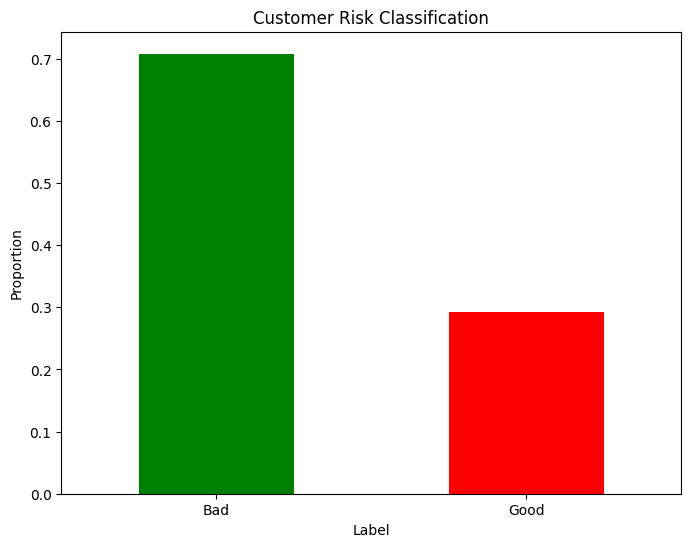

In [119]:
# Classify customers
df_labeled = assign_labels(df_rfms)
print("Label values after correction:", df_labeled['Label'].unique())

# Verify final labels
print("Final Label distribution:")
print(df_labeled['Label'].value_counts(dropna=False))

label_dist = df_labeled['Label'].value_counts(normalize=True)

print("\nLabel Distribution:")
print(label_dist)

plt.figure(figsize=(8, 6))
label_dist.plot(kind='bar', color=['green', 'red'])
plt.title('Customer Risk Classification')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.show()



In [120]:
print("Label value counts:\n", df_labeled['Label'].value_counts(dropna=False))

Label value counts:
 Label
Bad     2650
Good    1092
Name: count, dtype: int64


In [121]:
# Drop rows with NaN labels (if any)
df_labeled = df_labeled.dropna(subset=['Label'])

# Final verification
assert not df_labeled['Label'].isna().any(), "NaN values still exist in labels"
assert df_labeled['Label'].nunique() == 2, "Need exactly 2 classes"

## 3. WoE Binning Analysis

In [122]:
# Select features for binning

# Verify final labels
print("Final Label distribution:")
print(df_labeled['Label'].value_counts(dropna=False))

features = ['Recency', 'Frequency', 'Monetary', 'Stability']

# Convert label to numeric if needed
df_labeled['Label'] = df_labeled['Label'].map({'Good': 0, 'Bad': 1})

# Run WoE binning with positive class specified
bins = sc.woebin(df_labeled, y='Label', x=features, positive=1)

# Display results
print("\nWoE Binning Results:")
for feature in features:
    print(f"\n{feature} Bins:")
    display(bins[feature])

Final Label distribution:
Label
Bad     2650
Good    1092
Name: count, dtype: int64
[INFO] creating woe binning ...

WoE Binning Results:

Recency Bins:


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,Recency,"[-inf,2228.0)",1121,0.299572,36,1085,0.967886,2.519268,0.948421,1.410155,2228.0,False
1,Recency,"[2228.0,2274.0)",1717,0.458846,523,1194,0.695399,-0.061066,0.001733,1.410155,2274.0,False
2,Recency,"[2274.0,2302.0)",674,0.180118,425,249,0.369436,-1.421185,0.419579,1.410155,2302.0,False
3,Recency,"[2302.0,inf)",230,0.061464,108,122,0.530435,-0.764659,0.040422,1.410155,inf,False



Frequency Bins:


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,Frequency,"[-inf,2.0)",712,0.190273,143,569,0.799157,0.494487,0.041421,0.123932,2.0,False
1,Frequency,"[2.0,7.0)",1150,0.307322,275,875,0.760870,0.270904,0.021227,0.123932,7.0,False
2,Frequency,"[7.0,22.0)",990,0.264564,387,603,0.609091,-0.443056,0.056201,0.123932,22.0,False
3,Frequency,"[22.0,inf)",890,0.237841,287,603,0.677528,-0.144114,0.005083,0.123932,inf,False



Monetary Bins:


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,Monetary,"[-inf,10000.0)",1260,0.336718,105,1155,0.916667,1.511347,0.513397,0.806982,10000.0,False
1,Monetary,"[10000.0,80000.0)",1547,0.413415,500,1047,0.676794,-0.147473,0.009258,0.806982,80000.0,False
2,Monetary,"[80000.0,110000.0)",228,0.060930,141,87,0.381579,-1.369401,0.131861,0.806982,110000.0,False
3,Monetary,"[110000.0,inf)",707,0.188936,346,361,0.510608,-0.844110,0.152466,0.806982,inf,False



Stability Bins:


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,Stability,"[-inf,2.0)",1788,0.477819,470,1318,0.737136,0.144589,0.009681,0.237522,2.0,False
1,Stability,"[2.0,34.0)",1051,0.280866,388,663,0.630828,-0.350779,0.036875,0.237522,34.0,False
2,Stability,"[34.0,50.0)",301,0.080438,124,177,0.588040,-0.530681,0.024815,0.237522,50.0,False
3,Stability,"[50.0,82.0)",390,0.104222,102,288,0.738462,0.151439,0.002313,0.237522,82.0,False
4,Stability,"[82.0,inf)",212,0.056654,8,204,0.962264,2.352130,0.163838,0.237522,inf,False


## 4. Visualize Key Relationships

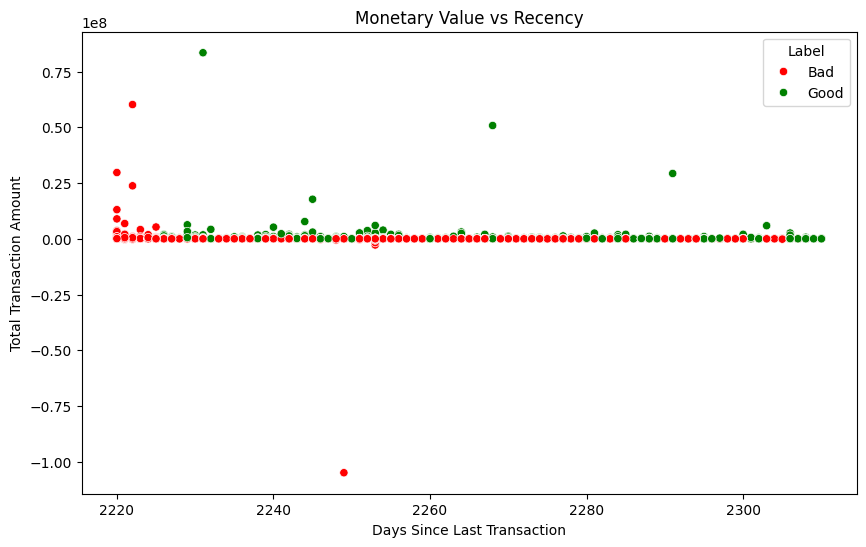

In [123]:
# Plot Monetary vs Recency
df_labeled['Label'] = df_labeled['Label'].map({0: 'Good', 1: 'Bad'})

# Plot Monetary vs Recency
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_labeled,
    x='Recency',
    y='Monetary',
    hue='Label',
    palette={'Good': 'green', 'Bad': 'red'}  # original string keys
)
plt.title('Monetary Value vs Recency')
plt.xlabel('Days Since Last Transaction')
plt.ylabel('Total Transaction Amount')
plt.show()

## 5. Save Labeled Data

In [124]:
# Save for modeling
LABELED_DATA = PROCESSED_DATA.parent / "labeled_data.parquet"
df_labeled.to_parquet(LABELED_DATA)
print(f"Labeled data saved to: {LABELED_DATA}")

Labeled data saved to: ..\data\processed\labeled_data.parquet
